In [963]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence
import ot #Optimal Transport


## Import functions for the experiment : 

from experiment_functions import *
from IPLA_Exp_Functions import *


dans un premier temps, à la zeub on prend une fonction de mapping connue, et on essaye de sample la posteriori sachant que la prior est une gaussian mixture classique 25 modes. 

Paramètres de la prior -> centres équirépartis entre -16 et 16. Unit variance et équipondérée

### Setting of the Experiment 

In this experiment, we will try to estimate the Maximum Marginal Likelihood with the Interacting Particle Langevin Algorithm (IPLA), as in the article : (...). But here we will try to improve / accelerate the sampling with the Dilation Path from the paper : (...). 

In this example, we take as a prior Distribution a Gaussian Mixture with 25 modes, whose parameters are defined bellow. Here is the statistical model that, we suppose, describes the relationship between x and y : (...). 

In [964]:
#We define the grid

x = np.linspace(-16, 16, 5)
y = np.linspace(-16, 16, 5)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers_prior = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances_prior = np.array([[[1, 0], [0, 1]]]*25)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights_prior = np.ones(25) / 25


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init = np.random.randn(1000, 2)


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

##Dimensions des variables

dx = 2

dy = 1

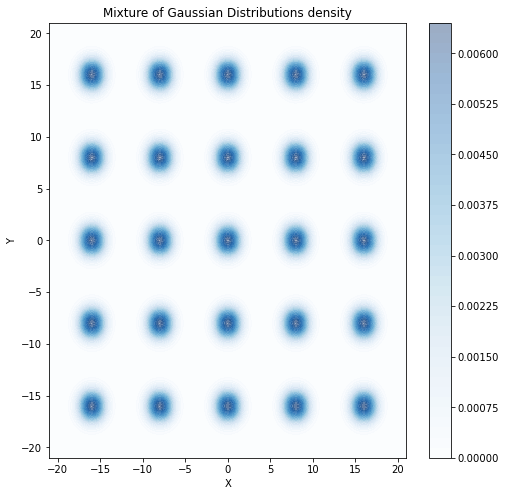

In [965]:
generate_multimodal(centers, covariances, weights)

In [966]:
x = ULA_dilation(sample_init, 15000, weights, centers, covariances, 0.1, 50, alpha = 0.01, vector_result=True)

  0%|          | 0/15000 [00:00<?, ?it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
  8%|▊         | 1212/15000 [00:22<04:15, 53.93it/s]


KeyboardInterrupt: 

Then, we have to define the other parameters of the experiment : $H$, $y$ and $\sigma_y$, as in the paper. We are able to plot the density of the "true" posterior distribution $p(x sachant y) $. 

Aucun sens la génération de l'opérateur H dans l'article qui pue la beuteu. Pb de dimension

In [ ]:
Id = np.eye(2)
#s_i_j = np.random.uniform(0, 1, 25)
#s_i_j.reshape((5, 5))
s_i_j = np.random.uniform(0, 1, 2)
H_tilde = np.random.randn(1, 2)
U, Sigma, Vt = np.linalg.svd(H_tilde, full_matrices=False)

Génération y comme dans l'article : 

First, we draw $x^{*}$ according to the prior distribution. And then, y = ...

On tire UN SEUL x* juste pour générer l'unique observations mais par la suite on aura plusieurs X qui seront les particules de l'algo. 

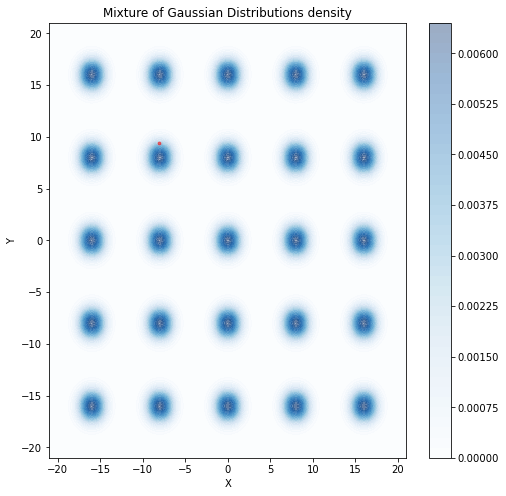

In [ ]:
nb_particle_gen = 1
nb_components = len(weights_prior)
x_star = np.zeros((nb_particle_gen, 2))

# Selection of the component randomly
component_choices = np.random.choice(nb_components, size=nb_particle_gen, p=weights_prior) #choix aléatoire entre les normales de la mixture (pondéré)

for i in range(nb_components):

    num_samples = np.sum(component_choices == i) #

    if num_samples > 0:

        #x_star[component_choices == i] = np.random.multivariate_normal(mean=centers[i], cov=covariances[i], size=num_samples) #pour les indices où l'on a tiré la composante en question on tire selon celle-ci
        x_star[component_choices == i] = np.random.multivariate_normal(mean=centers_prior[i], cov=covariances_prior[i], size=num_samples) 

generate_multimodal(centers_prior, covariances_prior, weights_prior, x_star)

We define function that, given $\theta$ and others parameters of the model, generates the centers, covariances and weights of the posterior distribution. We use the same prior. 

We suppose dy = 1

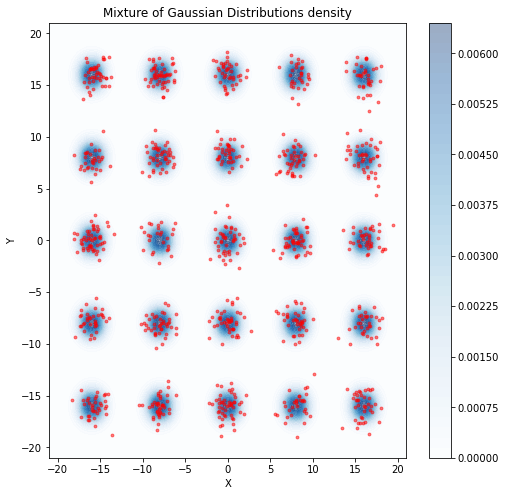

In [ ]:
x_star = sample_prior(1000, centers_prior, covariances_prior, weights_prior)

generate_multimodal(centers_prior, covariances_prior, weights_prior, x_star)

In [ ]:
y_obs = generate_obs(x_star[0], np.array([1, 2]), 0.1)

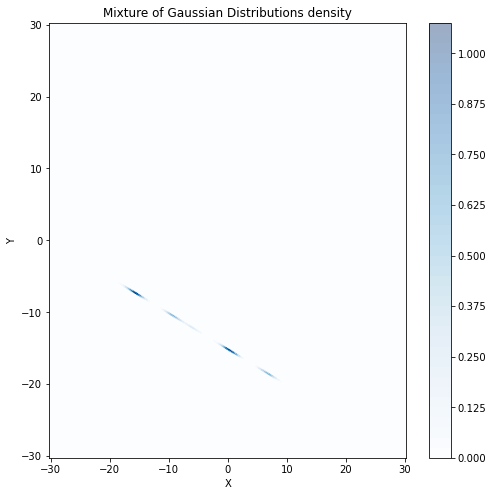

(array([[-12.45887807,  -8.91775614],
        [ -6.05568446, -12.11136892],
        [  0.34750915, -15.30498169],
        [  6.75070277, -18.49859447],
        [ 13.15389638, -21.69220724],
        [-15.65249085,  -7.30498169],
        [ -9.24929723, -10.49859447],
        [ -2.84610362, -13.69220724],
        [  3.55708999, -16.88582002],
        [  9.96028361, -20.07943279],
        [-18.84610362,  -5.69220724],
        [-12.44291001,  -8.88582002],
        [ -6.03971639, -12.07943279],
        [  0.36347722, -15.27304556],
        [  6.76667083, -18.46665834],
        [-22.03971639,  -4.07943279],
        [-15.63652278,  -7.27304556],
        [ -9.23332917, -10.46665834],
        [ -2.83013556, -13.66027111],
        [  3.57305806, -16.85388389],
        [-25.23332917,  -2.46665834],
        [-18.83013556,  -5.66027111],
        [-12.42694194,  -8.85388389],
        [ -6.02374833, -12.04749666],
        [  0.37944528, -15.24110944]]),
 array([[[ 0.8003992 , -0.3992016 ],
         [-

In [ ]:
post_params(np.array([1, 2]), 0.1, centers_prior, covariances_prior, weights_prior, y_obs, True)

Pas sûr de la façon dont on génère la posterior, mais bon on passe à la suite. 

### Interacting Particle Langevin Algorithm

Now that we have set the model of the experiment, our goal is to implement IPLA in order to find the MMLE with our observation. 

On commence l'algo a quel theta ? Et à la priori initiale ? 

We define a function that run IPLA with a dilation path on the SDE involving the particles, given a Gaussian Mixture prior. 

In [ ]:
def grad_theta_GM(x_t, theta_t, y_obs, sigma_y):
    """
    This function can compute the gradient of the log density of our LVM (potential function), with respect to the parameters theta. 
    """

    return (-1 / sigma_y**2) * (y_obs - np.dot(x_t, theta_t.T))[:, np.newaxis] * x_t

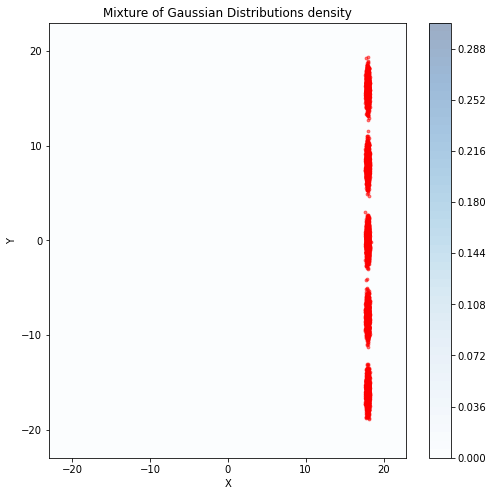

In [ ]:
generate_multimodal(centers_test, covariances_test, weights_test, sample_post)

First, we manually set a value for $H$ and we generate one observation, drawn as it is mentionned in the Appendix of the article : 

- $ x^* \sim p_0 $, où $ p_0 $ est une mixture gaussienne équipondérée avec $ K $ composants, centrés sur des points $\mu_k$ équirépartis dans le carré $[-16, 16]$ avec une covariance unitaire.
- $ y := Hx^* + z $, où $ z \sim \mathcal{N}(0, \sigma_y^2 I_{d_y}) $.

### Densité Jointe

La densité jointe $ p_\theta(x, y) $ est donnée par :

$ p_\theta(x, y) = p(y \mid x) p_\theta(x) $

où 

- $ p(y \mid x) = \mathcal{N}(y \mid Hx, \sigma_y^2 I_{d_y})$
- $ p_\theta(x) = \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) $

### Log-Densité Jointe

La log-densité jointe est donc :

$ \log p_\theta(x, y) = \log \mathcal{N}(y \mid Hx, \sigma_y^2 I_{d_y}) + \log \left( \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) \right) $

#### 1. Log de la Densité Conditionnelle

$ \log \mathcal{N}(y \mid Hx, \sigma_y^2 I_{d_y}) = -\frac{d_y}{2} \log(2\pi \sigma_y^2) - \frac{1}{2\sigma_y^2} (y - Hx)^T (y - Hx) $

#### 2. Log de la Densité A Priori

$\log p_\theta(x) = \log \left( \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) \right) $

### Gradient de la Log-Densité Jointe

Pour calculer le gradient de la log-densité jointe $\log p_\theta(x, y)$ par rapport à $x$ et $H$, nous dérivons chaque terme par rapport à ces variables.

#### Gradient par rapport à \(x\)

Le gradient de $\log p_\theta(x, y)$ par rapport à $x$ est :

$ \nabla_x \log p_\theta(x, y) = \frac{1}{\sigma_y^2} H^T (y - Hx) + \sum_{k=1}^K \frac{\mathcal{N}(x \mid \mu_k, I)}{K p_\theta(x)} (- (x - \mu_k)) $

#### Gradient par rapport à \(H\)

Le gradient de $\log p_\theta(x, y)$ par rapport à $H$ est :

$ \nabla_H \log p_\theta(x, y) = \frac{1}{\sigma_y^2} (y - Hx) x^T $


In [ ]:
true_theta = np.array([3, 2])

x_star = sample_prior(1, centers_prior, covariances_prior, weights_prior)

y_obs = generate_obs(x_star, true_theta, 0.1)

y_obs

array([60.12805822])

In order to confirm that we are able to correctly compute the score vecteur of the posteriori distribution given the "ground true" parameter $\theta$, we implement a gradient descent for several particles randomly drawn. We can then see that they converge to the modes of our a posteriori distribution. 

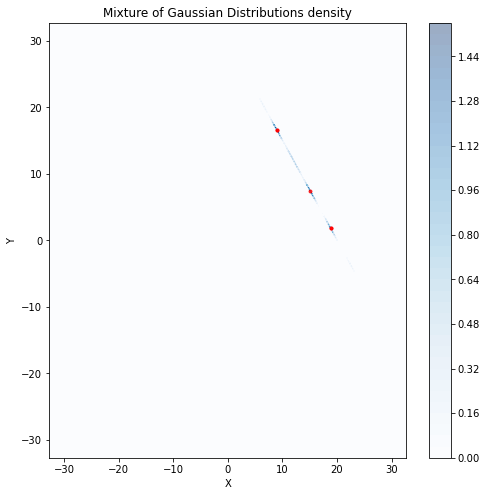

In [ ]:
#INIT
sample_init = np.random.randn(10, 2)*8

#We compute the parameters of the a posteriori, given the parametric statistical model and theta
centers_test, covariances_test, weights_test = post_params(true_theta, 0.1, centers_prior, covariances_prior, weights_prior, y_obs) 

traj = np.zeros((10000, 10, 2))

for i in range(10000): 
    
    #grad = grad_multimodal_opti(sample_init, weights_test, centers_test, covariances_test)
    grad = ((1/0.1**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

    grad += grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior)

    sample_init += 0.001 * grad

    traj[i] = sample_init

## we plot the result of the gradient descent
generate_multimodal(centers_test, covariances_test, weights_test, sample_init)

Here we plot the evolution of the position of the particles, and we can confirm that our formule for the score vector seems good as all particles converge to a mode of the distribution (which are local extrema of the log-density)

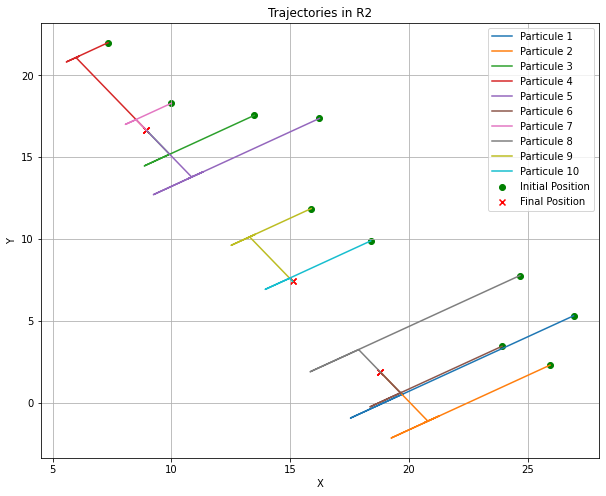

In [ ]:
# Trajectories of particles in R2
plt.figure(figsize=(10, 8))

for point_idx in range(traj.shape[1]):  # Pour chaque point (10 points au total)
    plt.plot(traj[:, point_idx, 0], traj[:, point_idx, 1], label=f'Particule {point_idx + 1}')

plt.scatter(traj[0, :, 0], traj[0, :, 1], color='green', marker='o', label='Initial Position')
plt.scatter(traj[-1, :, 0], traj[-1, :, 1], color='red', marker='x', label='Final Position')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectories in R2')
plt.legend()
plt.grid(True)
plt.show()

Now, we sample for the true posterior distribution and we do a classic gradient descent with the potentiel function (log-density), with respect to the parameter $\theta$. Then, we observe the convergence of the process to the true $\theta^{*}$ that we know. 

array([-0.00015298,  0.00042561])

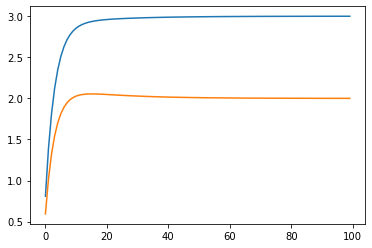

In [ ]:
sample_post = sample_prior(10000, centers_test, covariances_test, weights_test)

theta_t = np.array([0, 0])

theta_traj = np.zeros((100, 2))

step = 0.00001

for i in range(100) : 

    theta_t = theta_t - step * np.sum(grad_theta_GM(sample_post, theta_t, y_obs, 0.1) / 10000, axis = 0)

    #step *= 0.99

    theta_traj[i] = theta_t

plt.plot(np.arange(100), theta_traj)

theta_t - true_theta

The algorithm is very sensitive to the step size that need to be very small. 

array([-0.01441435, -0.00946312])

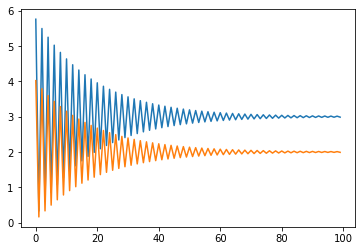

In [ ]:
sample_post = sample_prior(1000, centers_test, covariances_test, weights_test)

theta_t = np.array([0, 0])

theta_traj = np.zeros((100, 2))

step = 0.00007

for i in range(100) : 

    theta_t = theta_t - step * np.sum(grad_theta_GM(sample_post, theta_t, y_obs, 0.1) / 1000, axis = 0)

    #step *= 0.99

    theta_traj[i] = theta_t

plt.plot(np.arange(100), theta_traj)

theta_t - true_theta

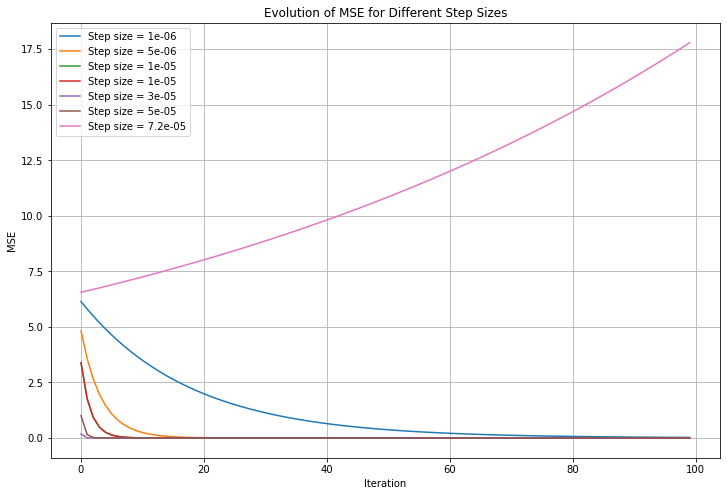

Final theta for different step sizes:
Step size = 1e-06, Final theta = [2.7736377  1.94786501]
Step size = 5e-06, Final theta = [2.99398842 2.00867361]
Step size = 1e-05, Final theta = [3.00009353 2.00031705]
Step size = 1e-05, Final theta = [3.00009353 2.00031705]
Step size = 3e-05, Final theta = [3.00052918 1.99972059]
Step size = 5e-05, Final theta = [3.00052919 1.99972059]
Step size = 7.2e-05, Final theta = [-1.81628358 -1.518537  ]


In [ ]:
sample_post = sample_prior(1000, centers_test, covariances_test, weights_test)

theta_t = np.array([0, 0])
step_sizes = [0.000001, 0.000005, 0.00001, 0.00001, 0.00003, 0.00005, 0.000072]
n_iterations = 100

plt.figure(figsize=(12, 8))

for step in step_sizes:
    theta_t = np.array([0.0, 0.0], dtype=np.float64)
    mse_traj = np.zeros(n_iterations)

    for i in range(n_iterations):
        grad = grad_theta_GM(sample_post, theta_t, y_obs, 0.1)
        theta_t -= step * np.sum(grad / 1000, axis=0)
        mse_traj[i] = np.mean((theta_t - true_theta) ** 2)

    plt.plot(np.arange(n_iterations), mse_traj, label=f'Step size = {step}')

plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Evolution of MSE for Different Step Sizes')
plt.legend()
plt.grid(True)
plt.show()

print("Final theta for different step sizes:")
for step in step_sizes:
    theta_t = np.array([0.0, 0.0], dtype=np.float64)
    for i in range(n_iterations):
        grad = grad_theta_GM(sample_post, theta_t, y_obs, 0.1)
        theta_t -= step * np.sum(grad / 1000, axis=0)
    print(f'Step size = {step}, Final theta = {theta_t}')

Therefore, we need to implement an adaptive step size for the equation updating theta. If we respect the algo, and we use the same step size to update the particles and the theta, theta may diverge if the step is too large or the particles we will converge to slowly to the posteriori distribution. 

Or maybe we can play on the coefficient of proportionnality on the step size for particles ? ? 

In [997]:
def PGD(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, coef_theta = 0.01, coef_particle = 0.01) : 
    
    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = 0

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_prior, centers_prior, covariances_prior) 

        grad_update = step_size * 70 * grad
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update 

        theta_traj[i] = theta_t

    centers_post, covariances_post, weights_post = post_params(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)

    generate_multimodal(centers_post, covariances_post, weights_post, sample)

    plt.plot(np.arange(nb_iter), theta_traj)

    return theta_t
    

100%|██████████| 1500/1500 [00:13<00:00, 114.46it/s]


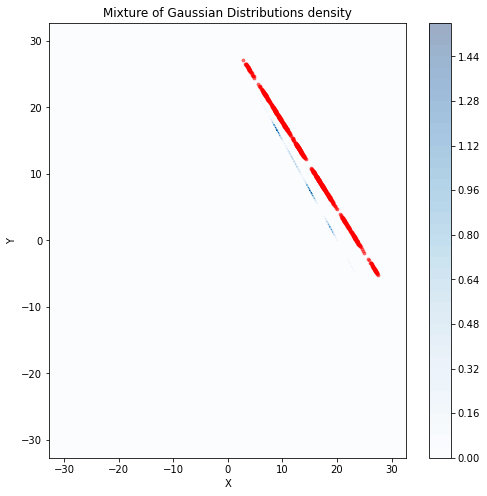

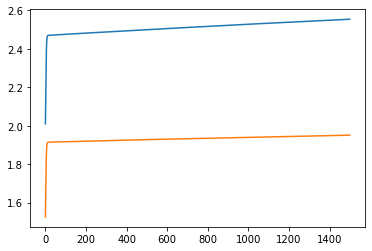

In [1026]:
traj = PGD(1000, 1500, 0.000005, centers_prior, covariances_prior, weights_prior, np.array([2, 1.5]), 0.1, y_obs)

In [1004]:
def IPLA(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, coef_theta = 0.01, coef_particle = 0.01) : 
    
    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = 0

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_prior, centers_prior, covariances_prior) 

        grad_update = step_size * 70 * grad
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_noise = np.sqrt(2 * step_size / nb_particles) * np.random.randn(2)

        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update + theta_noise

        theta_traj[i] = theta_t

    centers_post, covariances_post, weights_post = post_params(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)

    generate_multimodal(centers_post, covariances_post, weights_post, sample)

    plt.plot(np.arange(nb_iter), theta_traj)

    return theta_t
    

Here, we try the IPLA, which is very similar to PGD

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:22<00:00, 90.03it/s] 


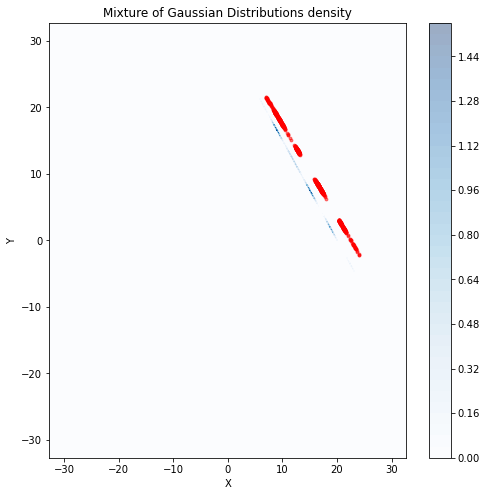

array([2.67172012, 1.92547847])

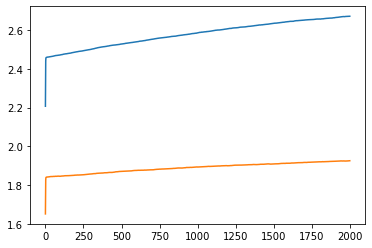

In [1025]:
IPLA(1000, 2000, 0.00001, centers_prior, covariances_prior, weights_prior, np.array([2, 1.5]), 0.1, y_obs)

Here, IPLA with the dilation path : 

In [1036]:
def IPLA_dilation(nb_particles, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs, 
                  start_schedule, end_schedule, bound = 100, alpha = 0.01) : 
    
    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior(nb_particles, centers_prior, covariances_prior, weights_prior)

    theta_traj = np.zeros((nb_iter, dx))

    time_SDE = np.zeros(nb_particles) #Each particle follows its own time-line 

    step_tab = np.full(nb_particles, start_schedule) 


    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step_tab

        schedule = np.minimum(end_schedule, time_SDE) / end_schedule #end_schedule is the date from which we are using the reel target distribution

        gamma = 1 / np.sqrt(schedule)

        gamma_sample = gamma[:, np.newaxis] * sample

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = gamma[:, np.newaxis] * ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, gamma_sample.T))).T 

        grad += gamma[:, np.newaxis] * grad_multimodal_opti(gamma_sample, weights_prior, centers_prior, covariances_prior) 

        #step_tab = np.minimum(1 / (np.linalg.norm(grad, axis = 1) + 1e-8), bound) * alpha
        step_tab = step_tab + np.full(nb_particles, step_size)

        #grad_update = step_tab[:, np.newaxis] * grad
        grad_update = step_size * 30 * grad
        
        #Noise
        #noise =  np.sqrt(2 * step_tab)[:, np.newaxis] * np.random.randn(nb_particles, dx)
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = gamma[:, np.newaxis] * grad_theta_GM(gamma_sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        #step_size_mean = np.nanmean(step_tab) / 100

        #theta_noise = np.sqrt(2 * step_size_mean / nb_particles) * np.random.randn(2)
        theta_noise = np.sqrt(2 * step_size / nb_particles) * np.random.randn(2)

        #theta_t = theta_t - (step_size_mean / nb_particles) * grad_theta_update + theta_noise
        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update + theta_noise

        theta_traj[i] = theta_t

    centers_post, covariances_post, weights_post = post_params(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)

    generate_multimodal(centers_post, covariances_post, weights_post, sample)

    plt.plot(np.arange(nb_iter), theta_traj)

    return theta_t
    

100%|██████████| 1500/1500 [00:20<00:00, 74.54it/s] 


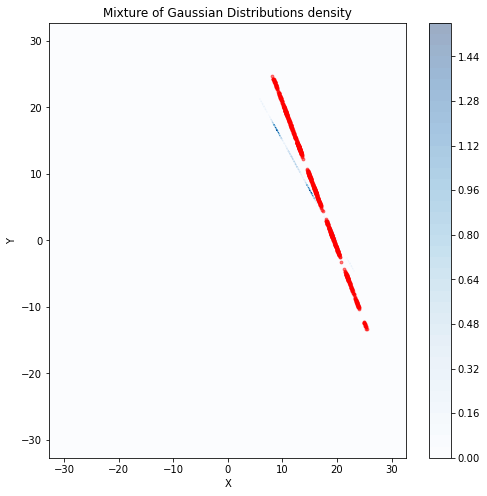

array([3.10654931, 1.40817215])

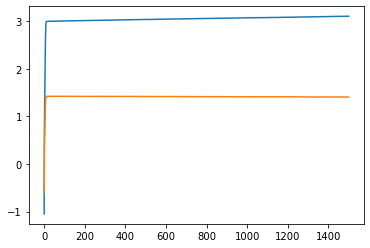

In [1041]:
IPLA_dilation(1000, 0.00001, 1500, centers_prior, covariances_prior, weights_prior, np.array([2, 1]), 0.1, y_obs, 1.9, 10, bound = 100, alpha = 0.01)